<a href="https://colab.research.google.com/github/pachterlab/monod_examples/blob/main/Monod_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Install prerequisites

In [153]:
# # %%capture
# # !pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# # !pip install -i https://pypi.org/simple/  monod  
# !pip install monod

Let's make sure that the version is correct.

In [154]:
# !pip show monod

## Import data

In [155]:
# ! git clone https://github.com/pachterlab/monod_examples.git

In [156]:
# !rm -r sample_data

In [157]:
# !mv monod_examples/* .

In [158]:
# !rm -r monod_examples

In [159]:
# !mv sample_data/* .

In [160]:
# !rmdir sample_data

In [161]:
# !cat allen_C01_gaba.tar.gz.* | tar xzvf -

In [162]:
# !mv home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom .

In [163]:
# !cat allen_C01_glu.tar.gz.* | tar xzvf -

In [164]:
# !mv home/ggorin/projects/monod_examples/sample_data/allen_C01_glu.loom .

In [165]:
# !rm -r  ./home

In [166]:
# !rm *.tar.*

## Import package components

In [167]:
# import monod
# from monod import preprocess, extract_data, cme_toolbox, inference, analysis

import matplotlib.pyplot as plt
import numpy as np

In [172]:
# execfile("src/monod/preprocess.py")
import sys
sys.path.insert(0, '/home/cat/monod/src/monod')

import extract_data, cme_toolbox, inference#, analysis

import importlib

importlib.reload(extract_data)
importlib.reload(cme_toolbox)
importlib.reload(preprocess)

importlib.reload(inference)

<module 'inference' from '/home/cat/monod/src/monod/inference.py'>

In [173]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Set up model and perform inference.

In [174]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Bernoulli')

# Perform inference.
new_adata = inference.perform_inference('./output_file_with_layers.h5ad', fitmodel, n_genes=2)

INFO:root:Directory output_file_with_layers already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: output_file_with_layers
INFO:root:728 cells detected.
3591 genes retained after expression filter.
INFO:root:2 random genes selected.
INFO:root:Total of 2 genes selected.
INFO:root:Data extracted
INFO:root:Search data created
INFO:root:Directory output_file_with_layers/Bursty_Bernoulli_6x7 already exists.
INFO:root:Global inference parameters stored to output_file_with_layers/Bursty_Bernoulli_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory output_file_with_layers/Bursty_Bernoulli_6x7/analysis_figures already exists.
ERROR:root:Grid scan results could not be stored to output_file_with_layers/Bursty_Bernoulli_6x7/grid_scan_results.res.
INFO:root:Runtime: 1.3 seconds.
INFO:root:Grid points fit.
INFO:r

## Access gene info.

In [175]:
# AIC.
display(new_adata.var[['AIC']])

# Optimum biological parameters.
display(new_adata.var[[i for i in new_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(new_adata.var[[i for i in new_adata.var.keys() if 'sigma' in i]])

,AIC
Ctif,103.077316
Tcf25,6.005555


,param_$\log_{10} b$,param_$\log_{10} \beta$,param_$\log_{10} \gamma$
Ctif,-0.678548,-1.800000,0.229363
Tcf25,-1.000000,-1.135126,3.420070


,sigma_$\log_{10} b$,sigma_$\log_{10} \beta$,sigma_$\log_{10} \gamma$
Ctif,-0.678548,-1.800000,0.229363
Tcf25,-1.000000,-1.135126,3.420070


Plot parameter distributions.

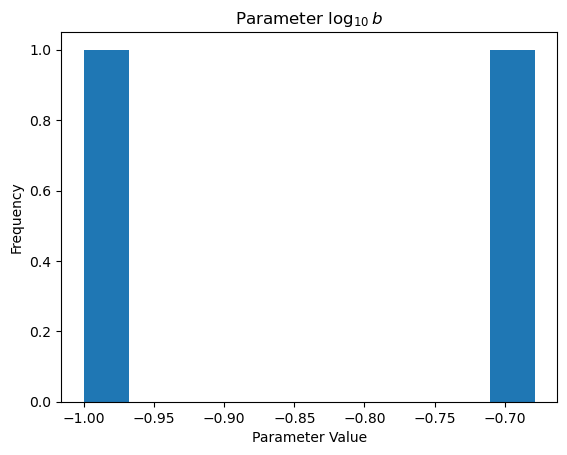

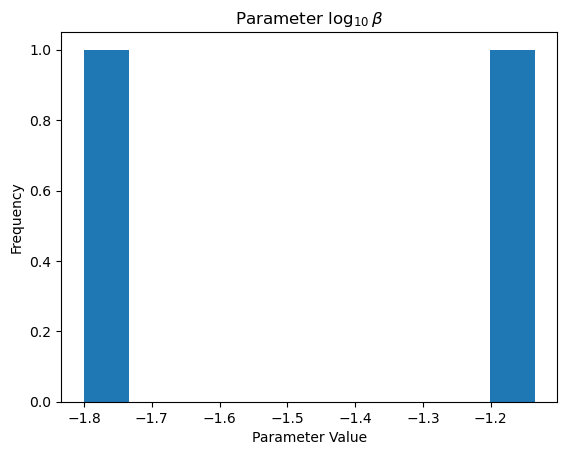

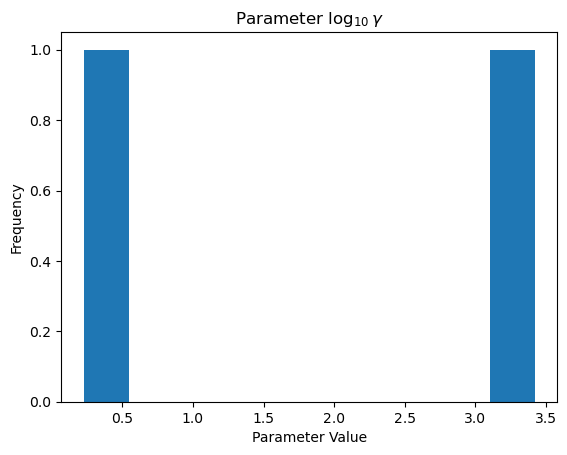

In [176]:
param_names = [i for i in new_adata.var.keys() if 'param' in i]
for name in param_names:
    plt.hist(new_adata.var[name])
    plt.title('Parameter ' + name[6:])
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

# Analysis (to be implemented)

## Reject genes.

In [ ]:
# Add rejection filter to adata.
adata = analysis.reject_genes(new_adata)

# Show rejected genes.
display(adata.var[adata.var[column_name]])
# Save chi-square values.
chi_squareds = adata.var['chi_squared']

## Execute differential expression analysis.

In [ ]:
# Compute FCs and p-values between groups in adata.
# This function should also store this information as .uns matrices in adata.
FCs, p_values = analysis.DE(adata)